# Customer Segmentation using K-Means Clustering
### *Strategic Grouping for Personalized Marketing and Business Insights*

## Objective
The goal of this module is to identify distinct groups of customers based on their purchasing behavior. By segmenting the customer base, the business can:
1. **Personalize Marketing:** Target specific groups with relevant offers.
2. **Optimize Resource Allocation:** Focus retention efforts on high-value segments.
3. **Understand Patterns:** Identify which types of customers prefer specific product lines or payment methods.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import display

# All libraries used in this notebook
import matplotlib.pyplot as plt



In [26]:
import os

DATA_PATH = "../data/processed/sales_staged.csv" 

# 2. Carregamento seguro
if os.path.exists(DATA_PATH):
    sales_raw = pd.read_csv(DATA_PATH)
    print("Dados carregados com sucesso via DATA_PATH!")
else:
    print("Arquivo não encontrado. Verifique se o caminho DATA_PATH está correto.")

# 3. Criando as variáveis para o modelo
try:
    features = ['Sales', 'Quantity', 'Rating'] 
    X = sales_raw[features].copy()
    
    # 4. Escalonamento
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Features selecionadas e escalonadas.")
except KeyError as e:
    print(f"Erro: Coluna não encontrada no CSV: {e}")


Dados carregados com sucesso via DATA_PATH!
Features selecionadas e escalonadas.


In [27]:
# Select features and scale (prefer existing variables to avoid overwriting)
try:
    X = cluster_data[['Sales', 'Quantity', 'Rating']].copy()
    source = 'cluster_data'
except NameError:
    sales_raw = pd.read_csv(DATA_PATH)
    X = sales_raw[['Sales', 'Quantity', 'Rating']].copy()
    source = 'DATA_PATH'

# Use existing scaled_features or scaler if available, otherwise create a new scaler
if 'scaled_features' in globals():
    X_scaled = scaled_features
    reused = 'scaled_features'
elif 'scaler' in globals():
    X_scaled = scaler.fit_transform(X)
    reused = 'scaler (refit)'
else:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    reused = 'new scaler'

print(f"Features selected from {source}: {list(X.columns)}")
print(f"Scaled data source: {reused}; shape: {X_scaled.shape}")

Features selected from DATA_PATH: ['Sales', 'Quantity', 'Rating']
Scaled data source: scaler (refit); shape: (1000, 3)


## Finding the Optimal Number of Clusters (The Elbow Method)
To determine how many groups (k) we should divide our customers into, we calculate the **Within-Cluster Sum of Squares (WCSS)**. We look for the "elbow" point where adding another cluster doesn't significantly improve the model.

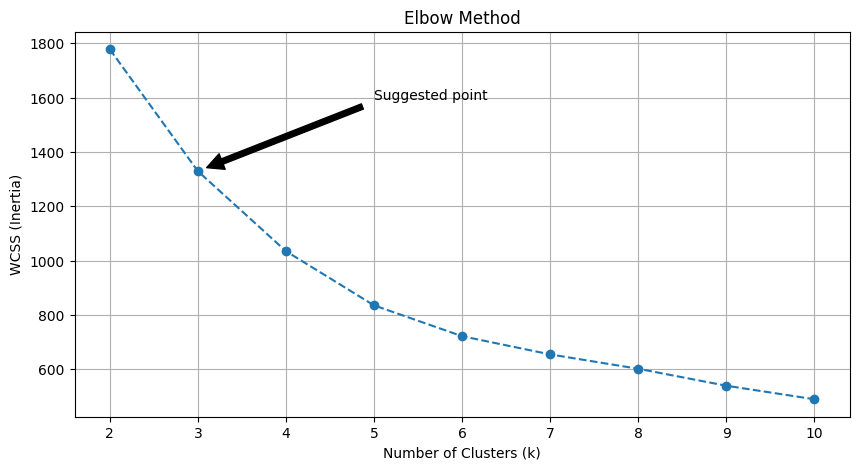

In [28]:
if 'plt' not in globals():
    import matplotlib.pyplot as plt

wcss = []
range_n_clusters = range(2, 11)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(list(range_n_clusters), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
k_suggest = 3
plt.annotate('Suggested point', xy=(k_suggest, wcss[k_suggest-2]), xytext=(k_suggest+2, wcss[k_suggest-2]*1.2),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.xticks(list(range_n_clusters))
plt.grid(True)
plt.show()

## Executing K-Means Clustering
Based on the Elbow Method, we will select **k=3** (Standard for Retail: High, Medium, and Low value customers).

In [29]:
# Definindo k=4 (Valor comum para segmentação básica: Low, Mid, High, Elite)
kmeans_final = KMeans(n_clusters=4, init='k-means++', random_state=42)
sales_raw['Cluster'] = kmeans_final.fit_transform(X_scaled).argmax(axis=1) # Adiciona ao sales_raw original

# Tradução dos perfis (Exemplo de interpretação)
cluster_map = {
    0: "Econômicos",
    1: "Premium (High Spend)",
    2: "Satisfeitos/Recorrentes",
    3: "Baixo Engajamento"
}
# Nota: Você deve validar as médias para nomear corretamente!

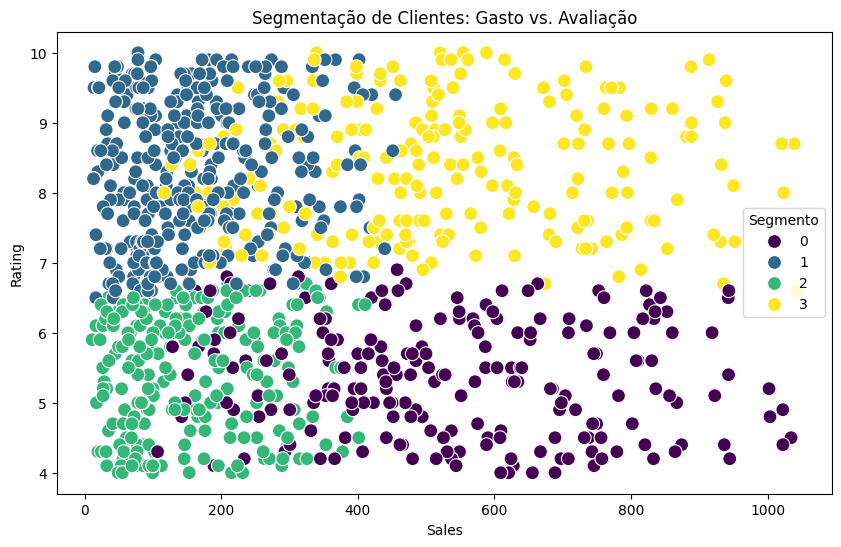

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sales_raw, x='Sales', y='Rating', hue='Cluster', palette='viridis', s=100)
plt.title('Segmentação de Clientes: Gasto vs. Avaliação')
plt.legend(title='Segmento')
plt.show()

In [31]:
# Analisando as médias de cada cluster
analysis = sales_raw.groupby('Cluster')[['Sales', 'Quantity', 'Rating']].mean().sort_values(by='Sales', ascending=False)
display(analysis)

,Sales,Quantity,Rating
Cluster,,,
3,536.498437,8.286385,8.344601
0,529.602675,8.154545,5.365455
1,168.153432,3.570571,8.284985
2,154.636327,3.256410,5.367521


## Strategic Insights & Business Actions

* **Cluster 0 (High Spenders):** Customers with high Sales values. 
    * *Action:* Enrollment in VIP loyalty programs.
* **Cluster 1 (High Satisfaction):** Customers who give high ratings but spend moderately.
    * *Action:* Referral programs to bring in new customers.
* **Cluster 2 (Low Volume):** Occasional shoppers with lower spending.
    * *Action:* Use discount coupons to increase purchase frequency.

In [32]:
sales_raw.to_csv("../data/processed/sales_with_clusters.csv", index=False)